In [11]:
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from pathlib import Path
import sys

In [12]:
def load_plant_data(filepath):
    df = pd.read_csv(filepath)
    return df.drop(columns=['Informant']).values

In [ ]:
data = load_plant_data('/Users/unasantos/Documents/GitHub/cogs107-docker/plant_knowledge.csv')
N, M = data.shape

with pm.Model() as Cultural_Consensus_Model:
    D = pm.Beta("D",alpha = 2, beta = 1, shape = N)
    Z = pm.Bernoulli("Z",p = 0.5, shape = M)

    D_reshaped = D[:,None]
    p = Z * D_reshaped + (1 - Z) * (1 - D_reshaped)

    Data_observations = pm.Bernoulli("Data_observations",p=p,observed = data)

    trace = pm.sample(draws = 2000, chains = 4, tune = 1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [D]
>BinaryGibbsMetropolis: [Z]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
D[0]   0.448  0.110   0.246    0.656      0.001    0.001    6594.0    4961.0   
D[1]   0.804  0.093   0.629    0.961      0.001    0.001    4185.0    4143.0   
D[2]   0.395  0.107   0.201    0.597      0.001    0.001    7391.0    5731.0   
D[3]   0.447  0.110   0.238    0.653      0.001    0.001    6977.0    4998.0   
D[4]   0.791  0.094   0.621    0.963      0.001    0.001    4841.0    3205.0   
D[5]   0.922  0.074   0.783    1.000      0.002    0.002    2618.0    3022.0   
D[6]   0.688  0.101   0.503    0.877      0.001    0.001    7291.0    4817.0   
D[7]   0.660  0.104   0.463    0.851      0.001    0.001    6898.0    5165.0   
D[8]   0.431  0.108   0.218    0.620      0.001    0.001    7691.0    4903.0   
D[9]   0.442  0.106   0.240    0.637      0.001    0.001    8446.0    5364.0   
Z[0]   0.021  0.144   0.000    0.000      0.002    0.007    4554.0    4554.0   
Z[1]   0.971  0.167   1.000    1.000    

/Users/unasantos/anaconda3/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/pairplot.py:233: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='D\n1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='D\n2'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='D\n3'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='D\n4'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='D\n5'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='D\n6'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='D\n7'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='D\n0', ylabel='D\n8'>, <Axes: xlabel='D\n1'>,
        <Axes: xlabel='D\n2'>, <Axes: xlabel='D\n3'>,
        <Axes: xlabel='D\n4'>, <Axes: xlabel='D\n5'>,
        <Axes: xlabel='D\n6'>, <Axes: xlabel='D\n7'>]

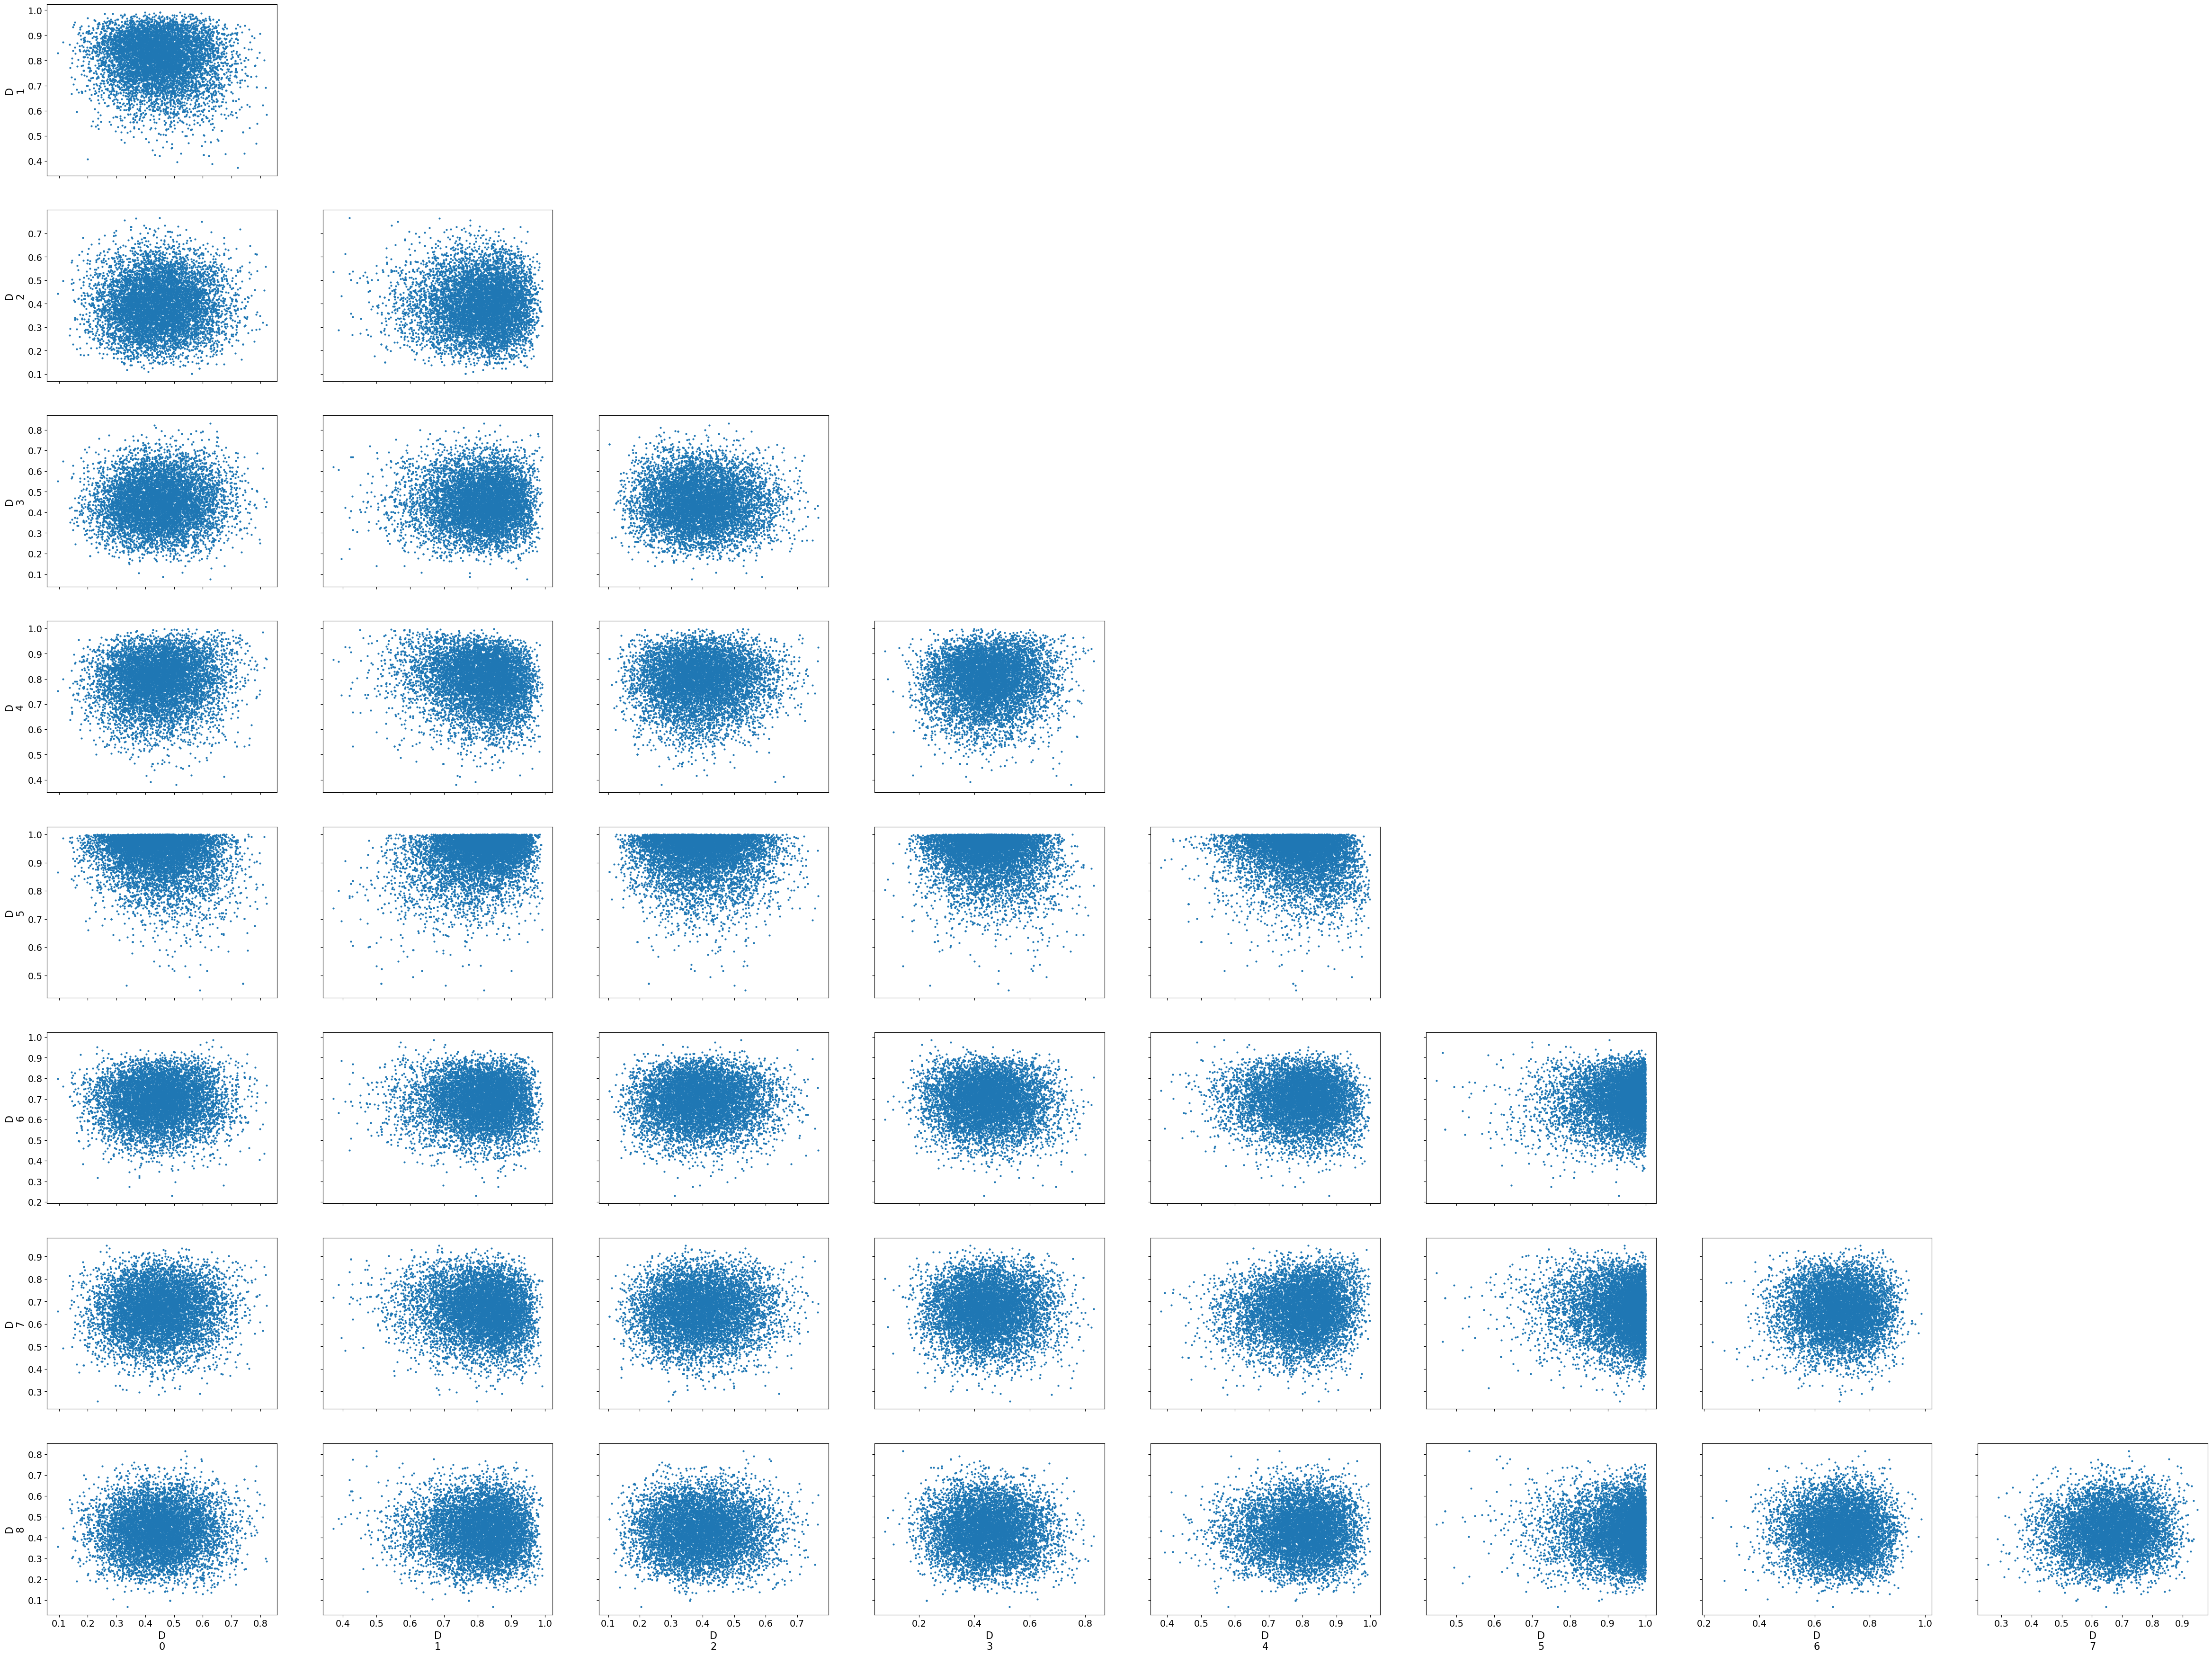

In [15]:
summary = az.summary(trace, var_names=["D", "Z"])
print(summary)
az.plot_pair(trace, var_names=["D", "Z"])

array([[<Axes: title={'center': 'Z\n0'}>,
        <Axes: title={'center': 'Z\n1'}>,
        <Axes: title={'center': 'Z\n2'}>,
        <Axes: title={'center': 'Z\n3'}>],
       [<Axes: title={'center': 'Z\n4'}>,
        <Axes: title={'center': 'Z\n5'}>,
        <Axes: title={'center': 'Z\n6'}>,
        <Axes: title={'center': 'Z\n7'}>],
       [<Axes: title={'center': 'Z\n8'}>,
        <Axes: title={'center': 'Z\n9'}>,
        <Axes: title={'center': 'Z\n10'}>,
        <Axes: title={'center': 'Z\n11'}>],
       [<Axes: title={'center': 'Z\n12'}>,
        <Axes: title={'center': 'Z\n13'}>,
        <Axes: title={'center': 'Z\n14'}>,
        <Axes: title={'center': 'Z\n15'}>],
       [<Axes: title={'center': 'Z\n16'}>,
        <Axes: title={'center': 'Z\n17'}>,
        <Axes: title={'center': 'Z\n18'}>,
        <Axes: title={'center': 'Z\n19'}>]], dtype=object)

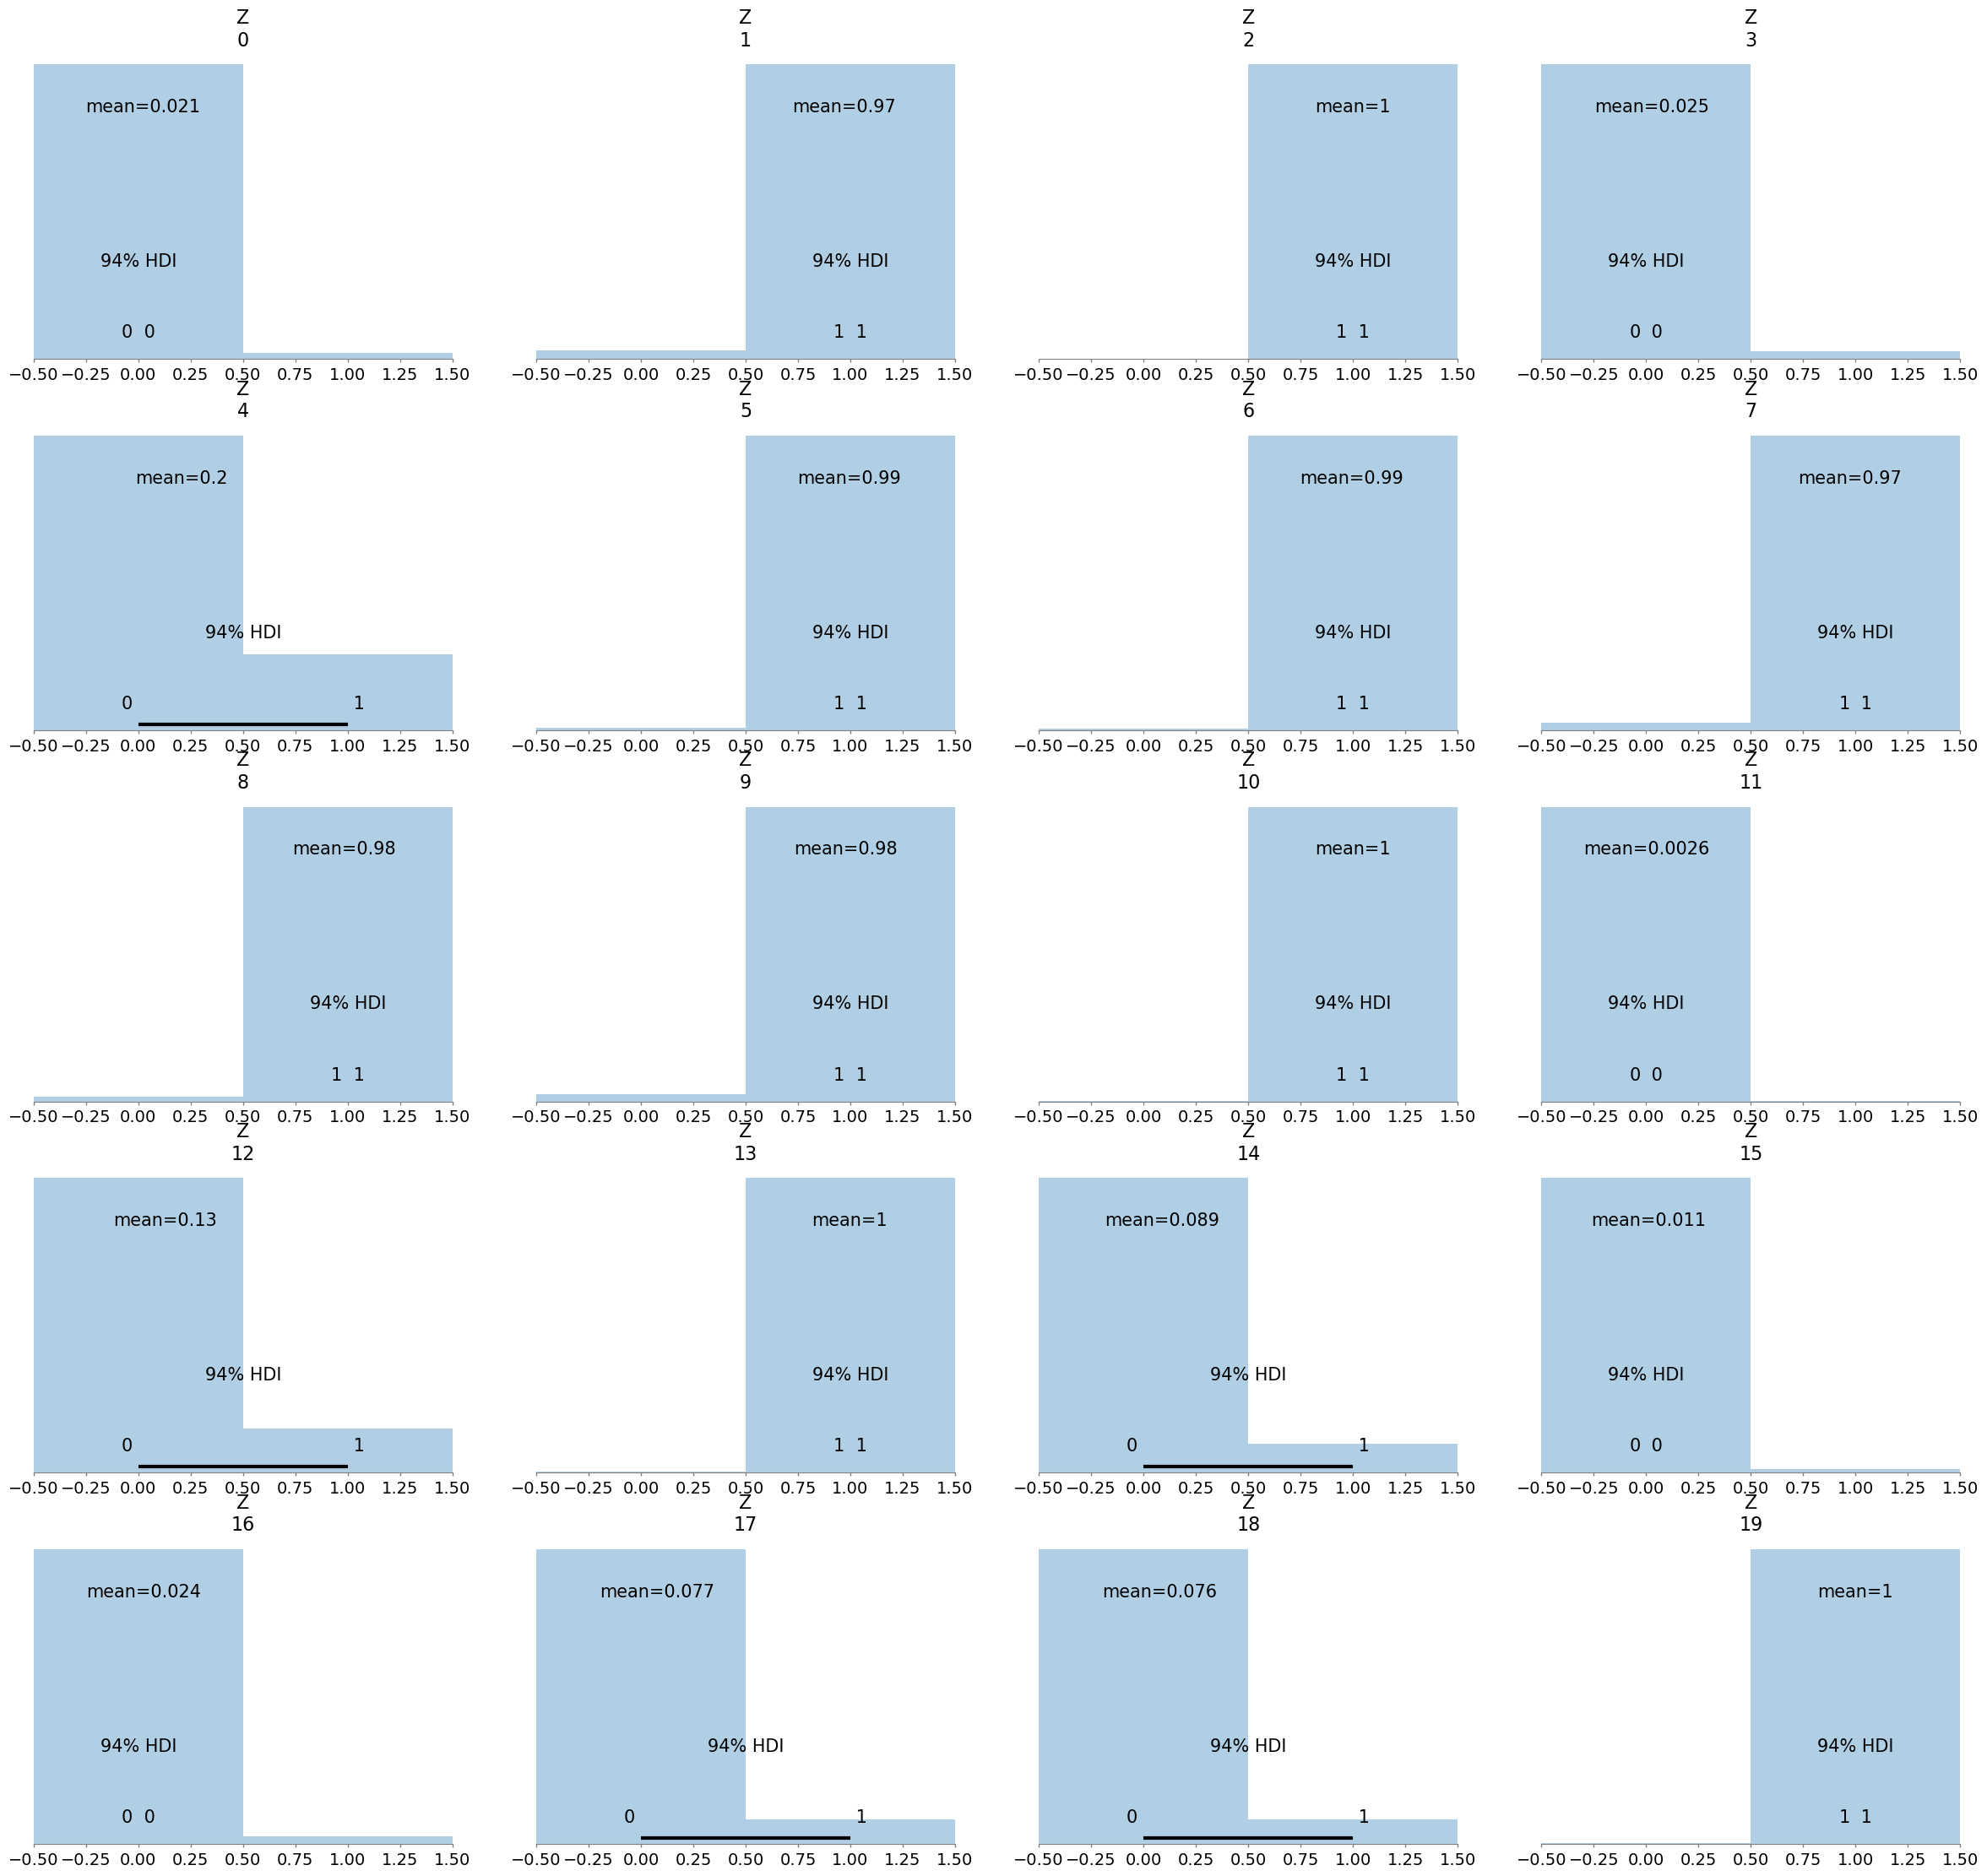

In [16]:
consensus_probs = trace.posterior["Z"].mean(dim=["chain", "draw"]).values
consensus_key = (consensus_probs >= 0.5).astype(int)
az.plot_posterior(trace, var_names=["Z"])

In [17]:
majority_vote = (data.mean(axis=0) >= 0.5).astype(int)

comparison_df = pd.DataFrame({
    "Consensus (CCT)": consensus_key,
    "Majority Vote": majority_vote,
    "Same?": consensus_key == majority_vote
})
print(comparison_df)

    Consensus (CCT)  Majority Vote  Same?
0                 0              0   True
1                 1              0  False
2                 1              1   True
3                 0              0   True
4                 0              1  False
5                 1              1   True
6                 1              1   True
7                 1              1   True
8                 1              1   True
9                 1              1   True
10                1              1   True
11                0              0   True
12                0              1  False
13                1              0  False
14                0              1  False
15                0              0   True
16                0              0   True
17                0              0   True
18                0              0   True
19                1              1   True
